# Изучение поведения пользоватей мобильного приложения.

**Описание проекта:**
Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 

**Наша задача:** 

**1) Изучить воронку продаж.** 
- Узнать, как пользователи доходят до покупки.
- Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
 
**2) Исследовать результаты A/A/B-эксперимента.** 
- Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. 
- Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.


**Ход исследования:** 
1. Загрузим и ознакомимся с данными
2. Проведём предобработку
3. Проверим данные перед началом исследования 
4. Подробно изучим воронку событий
5. Проведём анализ А/А теста
6. Проведём анализ А/В теста
7. Напишем выводы и рекомендации

# 1. Загрузим данные и подготовим их к анализу.

Данные находятся в файле: `/logs_exp.csv`. 
Импортируем нужные библиотеки в одну ячейку

In [4]:
# библиотека Pandas
import pandas as pd

# библиотеки математических вычислений
import numpy as np
import math as mth
import scipy.stats as st

# библиотеки визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt

# библиотека для преобразования к типу данных "дата"
import datetime as dt

# палитры графиков для людей со всеми типами зрения
sns.set_palette('colorblind') 
sns.set_style('whitegrid')            

##1.1. Загрузка данных
Загрузим файл и посмотрим информацию, которую содержит датасет.

In [6]:
# выставим ограничение на показ 2 знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

try:
    logs = pd.read_csv('/Users/stavrovalexander/Yandex_practicum/logs_exp.csv', sep='\t')
except:
    display('Ошибка данных')

display(logs.head(), logs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


None

Структура датасета `logs`:
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

1. Таблица (лог-файл) содержит 244 126 строк с записями о событиях.
2. В таблице нет пропусков.
3. Для удобства преименуем названия столбцов на следующем шаге. Приведём их к строчным буквам.
4. Приведём столбец `EventTimestamp` к типу данных `'datetime'` и добавим таблицы датой и временем и датой.

##1.2. Предварительная обработка данных и подготовка их к анализу:
Для начала переименуем названия столбцов

In [9]:
logs.columns = logs.columns = ['event', 'user_id', 'timestamp', 'group']
logs.head(2)

,event,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


Названия столбцов переименовали успешно. Добавим столбцы, содержащие даты и времени.

In [11]:
logs['datetime'] = pd.to_datetime(logs['timestamp'], unit='s')
logs['date'] = logs['datetime'].dt.date

display(logs.head(2), logs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user_id    244126 non-null  int64         
 2   timestamp  244126 non-null  int64         
 3   group      244126 non-null  int64         
 4   datetime   244126 non-null  datetime64[ns]
 5   date       244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


,event,user_id,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25


None

Посчитаем количество явных дубликатов и посчитаем какую долю занимают строки с дубликатами.

In [13]:
duplicate = logs.duplicated().sum()
print('Количество явных дубликатов:', duplicate)
print(f'Доля строк с дубликатами: {round(duplicate / len(logs) *100, 2)}%')

Количество явных дубликатов: 413
Доля строк с дубликатами: 0.17%


Такое количество строк с дубликатами составляет меньше 0,2% от общего количества. Мы можем их удалить.

In [123]:
logs = logs.drop_duplicates()
print('Количество явных дубликатов:', logs.duplicated().sum())

Количество явных дубликатов: 0


Отлично. Дубликатов не осталось. Заменим значения номеров экспериментов на более привычные названия групп А1/А2/B

In [17]:
def group_function(row):    
    """
    Функция возвращает тип теста по значению номера эксперимента 'group', используя правила:    
    - 'A1' - 'group' = 246 (контрольная группа с номером эксперимента 246),
    - 'A2' - 'group' = 247 (контрольная группа с номером эксперимента 247),
    - 'B' - 'group' = 248 (экспериментальная группа с номером 248),
    - 'Unknown'- во всех остальных случаях
    """            
    if row == 246:
        return 'A1'
    elif row == 247:
        return 'A2'
    elif row == 248:
        return 'B'
    else:
        return 'Unknown'
    
logs['group'] = logs['group'].apply(group_function)
logs.head(3)

,event,user_id,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25


Хорошо. Теперь группы имеют более привычные названия. Выведем ещё раз информацию о датасете и напишем вывод по 1 этапу.

In [19]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user_id    243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   group      243713 non-null  object        
 4   datetime   243713 non-null  datetime64[ns]
 5   date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 13.0+ MB


##1.3. Вывод по первому этапу исследований.

- Загрузили и познакомились с журналом событий `logs`;
- Заменили названия столбцов на удобные для нас;
- Проверили пропуски и типы данных. Откорректировали;
- Добавили столбец даты и времени, а также отдельный столбец дат;
- Удалили 413 строк с явными дубликатами;
- Провели категоризаци столбца с номером эксперимента на более привычные A1/A2/И тесты;
- Финальная таблица содержит 243 713 строк с информацией о событиях, соершённых пользователями нашего мобильного приложения.

Теперь получше познакомимся с данными и проверим их на следующем этапе.

---

#2. Изучим и проверим данные.

##2.1. Узнаем сколько всего событий в логе

In [22]:
events_all = logs['event'].count()
print('Всего событий в логе:', events_all)

Всего событий в логе: 243713


Количество событий в логе совпадает с количеством строк в датасете после предобработки. 243 713 событий.
Посмотрим как распределились события по количеству.

In [24]:
print('Количество событий по наименованию:\n', logs['event'].value_counts())

Количество событий по наименованию:
 event
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64


- Чаще всего происходило событие `MainScreenAppear` (демонстрация главного экрана). Это логично. Пользователи начинают свой путь в приложении с первого экрана.

Дальше по количеству идут: 
- `OffersScreenAppea` - показ экрана с предложением, 
- `CartScreenAppear` - показ экрана корзины,
- `PaymentScreenSuccessful` - показ экрана с подтверждением оплаты,
- `Tutorial` - показ обучения

##2.2. Cколько всего пользователей в логе

In [26]:
users_all = logs['user_id'].nunique()
print('Всего пользователей в логе:', users_all)

Всего пользователей в логе: 7551


##2.3. Сколько в среднем событий приходится на пользователя?

Сгруппируем таблицу по количеству событий на пользователя и выведем список характерных значений. 

In [28]:
logs_mean = logs.groupby('user_id')['event'].count()
logs_mean.describe()

count   7,551.00
mean       32.28
std        65.15
min         1.00
25%         9.00
50%        20.00
75%        37.00
max     2,307.00
Name: event, dtype: float64

Видно, что:
- среднее количество событий на одного пользователя - 32
- медианное значение - 20
- максимальное количество событий на одного пользователя - 2 307
- минимальное - 1

Есть выбросы по количеству событий на пользователя. То есть, пользователи, совершившие аномально большое количество событий. Построим диаграмму размаха и посмотрим много ли выбросов.

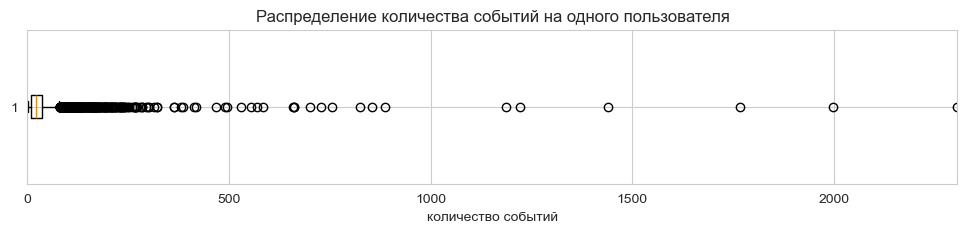

In [125]:
plt.figure(figsize=(12, 2))
plt.boxplot(logs_mean, vert=False)  # горизонтальный boxplot
plt.xlim(0, 2307)
plt.title("Распределение количества событий на одного пользователя") 
plt.xlabel("количество событий")

plt.show()

Видны одиночные кружки (пользователи с аномально большим числом событий), которые постепенно сливаются в одну сплошную линию. 

"Ящика с усами" почти не видно из-за такого количества выбросов. Для такого случая логично принять среднее (медианное) значение. Оно будет более точно отражать картину, чем простое среднее значение.

Среднее (медианное) событий на пользователя - 20.

##2.4. Данными за какой период мы располагаем? 

###2.4.1. Определим максимальную и минимальную даты.

In [33]:
print('Дата первой записи:', logs['datetime'].min())
print('Дата последней записи:', logs['datetime'].max())

Дата первой записи: 2019-07-25 04:43:36
Дата последней записи: 2019-08-07 21:15:17


В лог-файле мы имеем дело записями  в период с 25 июля по 7 августа 2019 года. Это максимальная и минимальная дата.  Период записей в нашем файле меньше 2ух недель.

###2.4.2.  Изучим, как меняется количество данных в зависимости от времени в разрезе групп.

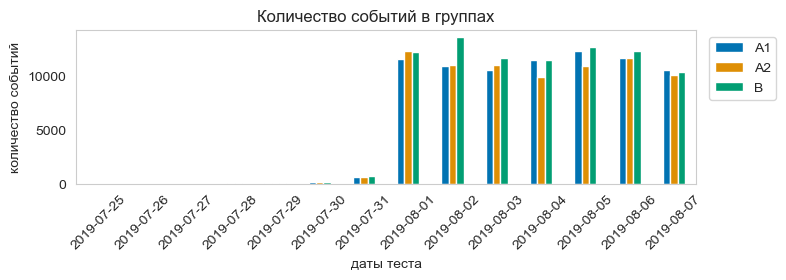

In [35]:
# создадим сводную, которая отображает распределение количества событий по датам в разрезе групп
ax = logs.pivot_table(
    index='date',
    columns='group',
    values='user_id',
    aggfunc='count').plot(kind='bar', figsize=(8, 2))

plt.suptitle('Количество событий в группах')
plt.xlabel('даты теста')
plt.ylabel('количество событий')
plt.xticks(rotation=45) 
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left') 
ax.grid(False)
plt.show()

Видно, что события во всех группах происходили в один и тот же период.
    С 30 июля по 8 августа. Однако, 30 и 31 июля произошло совсем немного событий во всех группах пользователей.
Посмотрим как происходило распределение каждого события по времени. Так мы можем быть уверены, что все события вошли во временной промежуток с 1 августа 2019 года.

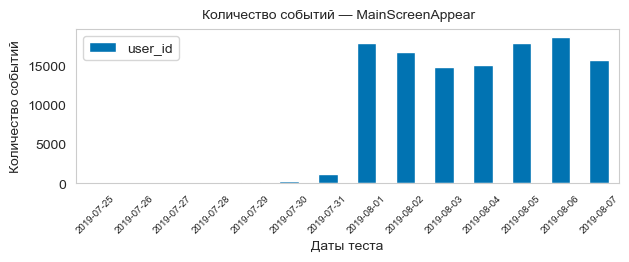

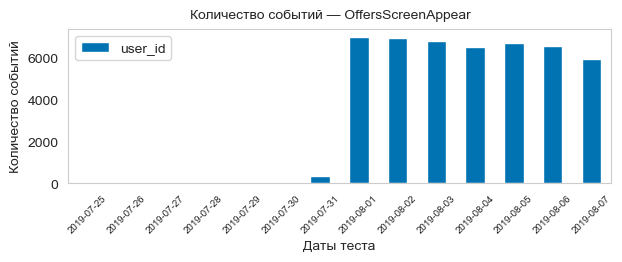

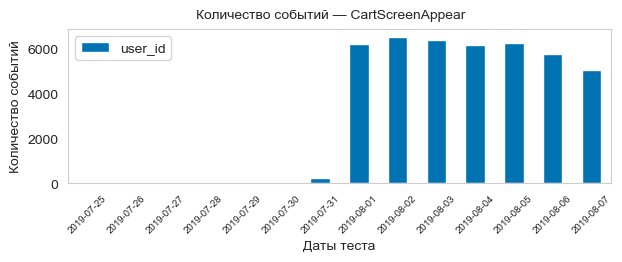

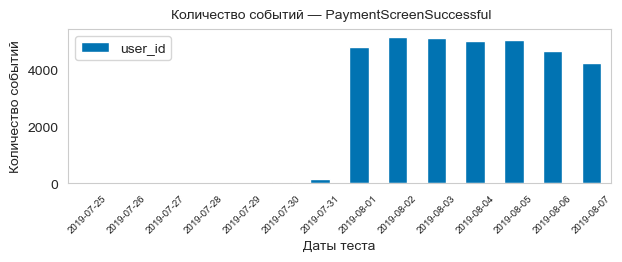

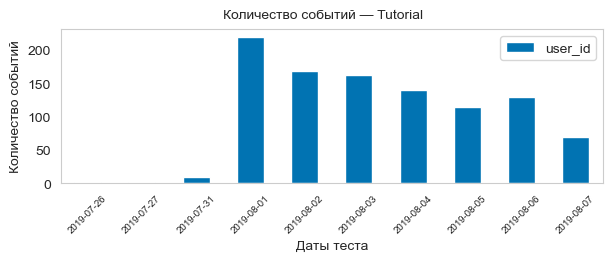

In [37]:
# создадим срез из событий в журнале:
temp = logs.groupby('event')['user_id'].count().sort_values(ascending=False).index[:5]

for event in temp:  # цикл для среза по событиям    
    ax = logs[logs['event'] == event].pivot_table(
        index='date',
        values='user_id',
        aggfunc='count').plot(kind='bar', figsize=(7, 2))

    plt.suptitle(f'Количество событий — {event}', fontsize=10)
    plt.xlabel('Даты теста')
    plt.ylabel('Количество событий')
    plt.xticks(rotation=45, fontsize=7)
    ax.grid(False)
    plt.show()

Если смотреть отдельно каждое событие, то видно, что динамика событий неравномерна, но всё равно, события приходятся на вторую половину периода. 

###2.4.3. Выберем период исследований:
Выберем дату отсечения - 1 августа. То есть, отсечём события, которые проиходили до этой даты. И посмотрим много ли данных мы потеряли.

In [39]:
logs_new = logs.loc[logs['datetime'] > '2019-07-31 23:59:59']  # новый срез даных с 1 августа

print('Дата первой записи по срезу:', logs_new['datetime'].min())
print('Дата последней записи по срезу:', logs_new['datetime'].max())

Дата первой записи по срезу: 2019-08-01 00:07:28
Дата последней записи по срезу: 2019-08-07 21:15:17


###2.4.4. Много ли событий и пользователей мы потеряли, отбросив старые данные?

In [41]:
events_new = logs_new['event'].count()   # осталось событий

print('Было в начале исследования:', events_all, 'событий')
print('Было отсечено по дате:', events_all - events_new, 'событий')
print('Осталось:', events_new, 'событий')

print(f'\nДоля отсечённых событий: {round((events_all - events_new) / events_all*100, 2)}%')

Было в начале исследования: 243713 событий
Было отсечено по дате: 2826 событий
Осталось: 240887 событий

Доля отсечённых событий: 1.16%


In [42]:
users_new = logs_new['user_id'].nunique()   # осталось пользователей

print('Было в начале исследования:', users_all, 'пользователей')
print('Было отсечено по дате:', users_all - users_new, 'пользователей')
print('Осталось:', users_new, 'пользователей')

print(f'\nДоля отсечённых пользователей: {round((users_all - users_new) / users_all*100, 2)}%')

Было в начале исследования: 7551 пользователей
Было отсечено по дате: 17 пользователей
Осталось: 7534 пользователей

Доля отсечённых пользователей: 0.23%


Итак, мы отсекли данные:
- по 2 826 событиям из 243 713 строк событий, что составило 1,16% от данных, 
- по 17 уникальным пользователям из 7 551 строк с пользователями, что составило 0,23% от данных.

Мы отсекли не существенную долю даных и можем продолжить. 

###2.4.5. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.
Для начала посмотрим количество пользователей в каждой группе после отсечения данных.

In [44]:
logs_new.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Проверим есть ли пересечения в группах. 
Для этого посмотрим есть ли пользователи, которые участвовали более чем в 1 группе теста. 

In [46]:
logs_new.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


Таких пользователей не обнаружено. Выяснили, что пересечений уникальных пользователей в этих группах нет. Значит пользователи совершали события внутри своих групп до конца теста.
    
Это одно из условий того, что тест проведён корректно.

##2.5. Разберём воронку событий.

###2.5.1. Посмотрим, какие события есть в логах, как часто они встречаются. 
Отсортируем события по частоте.

,event_count
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


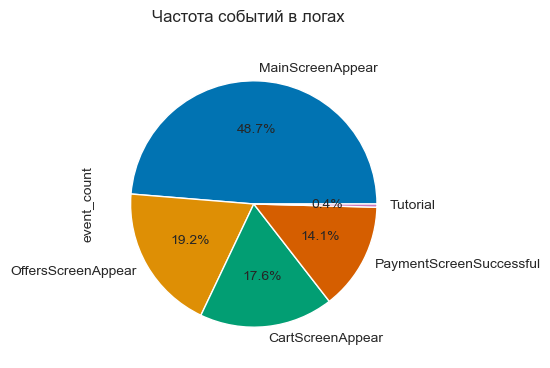

In [49]:
# сделаем сводную событий по их количеству
events_count = logs_new.pivot_table(            
        index='event',
        values='user_id',
        aggfunc='count').sort_values(by='user_id', ascending=False)

events_count.columns = ['event_count']
display(events_count)

events_count.plot(
    subplots=True,
    kind='pie',
    figsize=(4, 4),
    autopct = '%1.1f%%',
    legend = False,
    title='Частота событий в логах')
plt.show()

Как и писали выше, у нас 5 событий, но после отсечения даты их количество немного изменилось.
- Чаще всего происходило событие `MainScreenAppear` (демонстрация главного экрана) - 48,7%
- дальше по убыванию `OffersScreenAppea` - показ экрана с предложением - 19,2%, 
- `CartScreenAppear` - показ экрана корзины - 17,6%,
- `PaymentScreenSuccessful` - показ экрана с подтверждением оплаты - 14,1%,
- `Tutorial` - показ обучения - 0,4%

###2.5.2. Посчитаем, сколько пользователей совершали каждое из этих событий. 

- Отсортируем события по числу пользователей. 
- Посчитаем долю пользователей, которые хоть раз совершали событие.

In [52]:
# сделаем сводную событий по количеству уникальных пользователей на событие
events_user = logs_new.pivot_table(
    index='event',
    values='user_id',
    aggfunc='nunique').sort_values(by='user_id', ascending=False)

events_user.columns = ['users']
events_user['ratio'] = round(events_user['users'] / users_new*100, 2)

events_user 

,users,ratio
event,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


###2.5.3. Предположим, в каком порядке происходят события. Все ли события выстраиваются в последовательную цепочку? 

События происходят в следующем порядке. 
Пользователь:
- видит главный экран сайта - `MainScreenAppear`
- переходит на экран с товаром - `OffersScreenAppea`
- добавляет товар в корзину и переходит на экран корзины - `CartScreenAppear`
- оплачивает заказ и переходит на экран успешной оплаты - `PaymentScreenSuccessful`

Так же есть событие - переход на страницу обучения - `Tutorial`. Как правило, все приложения содержат информационный раздел.Но этот раздел не является обязательным и не входит в воронку. Кроме того, доля таких событий всего 0,4%. 

Интересно, что главный экран видят не все пользователи. Из 7 534 оставшихся после отсечения пользователей событие `MainScreenAppear` произошло только для 7 419.
- либо демонстрация главного экрана не является первым событием в воронке (и мы его не видим в отчётах). Маловероятно.
- либо по каким-то техническим причинам первый экран показывается не всем. (не установлено обновление, не грузится на опредлённых устройствах и тд). Потеря конверсии сразу на первом шаге воронки бывает, но наша задача обратить на это внимание тоже.


###2.5.4. Расчёт воронки событий
По воронке событий посчитаем 
- какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [54]:
sales_funnel = (logs_new.query('event != "Tutorial"')  # отсечём событие 'Tutorial'
    .groupby('event')['user_id'].nunique()             # группируем таблицу по событию и количеству уникальных пользователей
    .sort_values(ascending=False).reset_index()
    .rename(columns={'user_id': 'users'}))

sales_funnel['conversion'] = round(sales_funnel['users'] / 
                                   sales_funnel['users']
                                   .shift(periods=1, fill_value=sales_funnel['users'][0])*100, 2)
sales_funnel

,event,users,conversion
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


Видим таблицу, котрая показывает процент конверсии каждого этапа воронки:
- `event` - событие,
- `users`- количество уникальных пользователей на событие,
- `conversion` - конверсия от предыдущего этапа воронки.


1) На экран с товарным предложением проходит 61,9% пользователей, видевших главный экран. 

2) После просмота товара в корзину переходит 81,3% пользователей. Высокий показатель. Это говорит о том, что карточки товара хорошо мотивируют пользователя добавить товар в корзину.

3) На экран с успешной оплатой переходит 94,8% пользователей. Это говорит о том, что если пользователь уже добавил товар в корзину, то 94,8% из них совершат покупку. Мало "брошенных корзин".

###2.5.5. На каком шаге теряем больше всего пользователей?

"Слабое звено" в воронке — это этап перехода с главного экрана в карточку товара. Здесь самые низкие показатели конверсии - 61,9% 

Мы не можем сказать насколько это высокий или низкий показатель, но точно можем сказать, что он ниже всех остальных этапов воронки интернет-магазина.

Обычно, для каждого этапа есть свои характерные показатели конверсии по переходам. 

В нашем случае, мы можем предположить, главный экран сайта не удобный или не понтяный для пользователей. Возможно, есть технические проблемы, например скорость загрузки.

###2.5.6. Какая доля пользователей доходит от первого события до оплаты?

In [58]:
# создадим переменные первого и последнего шагов воронки
main_screen = sales_funnel['users'].loc[sales_funnel.index[0]]
payment_screen = sales_funnel['users'].loc[sales_funnel.index[-1]]

print(f'Доля пользователей, дошедших от первого события до оплаты: \
{round(payment_screen / main_screen*100, 2)}%')                                      

Доля пользователей, дошедших от первого события до оплаты: 47.7%


###2.5.7. Сделаем визуализацию воронки продаж

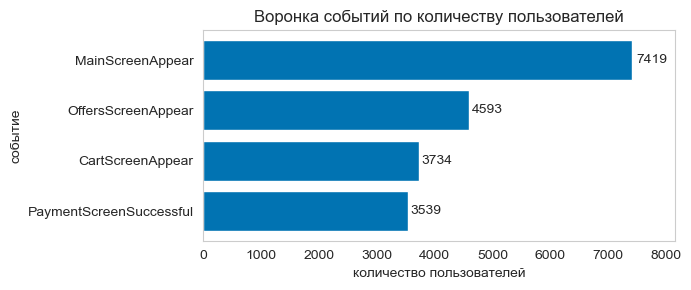

In [60]:
plt.figure(figsize=(7, 3))

bars = plt.barh(sales_funnel['event'], sales_funnel['users'])

for bar in bars:                   # добавляем подписи
    plt.text(bar.get_width() * 1.01, 
             bar.get_y() + bar.get_height() / 2, 
             int(bar.get_width()), va='center', clip_on=False)

plt.xlabel("количество пользователей")
plt.ylabel("событие")
plt.title("Воронка событий по количеству пользователей")
plt.gca().invert_yaxis()
plt.grid(False)
plt.xlim(0, sales_funnel['users'].max() * 1.1)
plt.tight_layout()
plt.show()

###2.5.8. Вывод по анализу воронки продаж:

- Разобрали какие есть события и как часто встречаются:
    - `MainScreenAppear` (демонстрация главного экрана) - 117 328 раз (48,7%);
    - `OffersScreenAppea` - показ экрана с предложением - 46 333 раза (19,2%);
    - `CartScreenAppear` - показ экрана корзины - 42 303 раза (17,6%);
    - `PaymentScreenSuccessful` - показ экрана с подтверждением оплаты - 33 918 раз (14,1%);
    - `Tutorial` - показ обучения - 1 005 раз (0,4%).


- В таком порядке события и происходят


- Посчитали, сколько пользователей совершали каждое из событий и долю пользователей, которые хоть раз совершали это событие:

    - `MainScreenAppear` - 7 419 пользователей;
    - `OffersScreenAppea` - 4 593 пользователей;
    - `CartScreenAppear` - 3 734 пользователей;
    - `PaymentScreenSuccessful` - 3 539 пользователей;
    - `Tutorial` - 840 пользователей.  


- Событие `Tutorial` было отсчено, так как не является шагом воронки.


- Посчитали конверсию перехода на каждом последующем шаге воронки событий :
    - 1 этап - 100%
    - 2 этап - 61.9%
    - 3 этап - 81.3%
    - 4 этап - 94.8%


    
- Выяснили, что больше всего пользователей теряется на втором этапе воронки. Переход с главного экрана в карточку товара.

- Посчитали долю пользователей прошедших от первого события до оплаты 47.7%.
---

##3. Изучим результаты эксперимента.

###3.1. Сколько пользователей в каждой экспериментальной группе?
Создадим список с количеством пользователей в каждой группе

In [63]:
users_by_group = logs_new.groupby('group')['user_id'].nunique()

# для дальнейших расчётов нам понадобится сумма пользователей в контрольных группах А1/А2
users_by_group['sum_A'] = users_by_group[['A1','A2']].sum()
users_by_group

group
A1       2484
A2       2513
B        2537
sum_A    4997
Name: user_id, dtype: int64

In [64]:
print(f'Отличие в количестве пользователей групп А1/А2: \
{round(users_by_group["A1"] / users_by_group["A2"], 2)} %')

print(f'Отличие в количестве пользователей групп А1/B: \
{round(users_by_group["A1"] / users_by_group["B"], 2)} %')

print(f'Отличие в количестве пользователей групп А2/B: \
{round(users_by_group["A2"] / users_by_group["B"], 2)} %')

Отличие в количестве пользователей групп А1/А2: 0.99 %
Отличие в количестве пользователей групп А1/B: 0.98 %
Отличие в количестве пользователей групп А2/B: 0.99 %


Количество пользователей, попавших в различные группы, отличается не более, чем на 1%.
Проверим есть ли статистическая разница между группами А/А теста и проверим насколько корректно работало разбиение на группы.

#### Можно ли сказать, что разбиение на группы работает корректно?

- Выберем самое популярное событие. 
- Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп.
- Посчитаем долю пользователей, совершивших это событие. 
- Проверим, будет ли отличие между группами статистически достоверным и сделаем то же самое для всех других событий.

Сделаем ряд шагов, чтобы проверить, что разбиение на группы работает корректно.

- 1) Создадим сводную, где разберём каждое событие по количеству пользователей в каждой группе А1/А2/В.
- 2) Посчитаем долю пользователей, совершивших эти события.
- 3) Создадим функцию для проведения двустороннего теста.
- 4) Зададим нулевую и альтернативную гипотезы и проверим их.
- 5) Сделаем вывод.

##### Создадим сводную таблицу событий в разрезе каждой группы А1/А2/В.
Добавим столбец с объединённой контрольной группой А1/А2 и столбцы с долей пользователей, совершивших событие к общему числу пользователей в разрезе событий.

In [67]:
event_group_test = logs_new[logs_new['event']!='Tutorial'].pivot_table(
    index='event', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False).reset_index()

event_group_test['sum_A'] = event_group_test[['A1','A2']].sum(axis=1)

event_group_test['share_A1'] = (event_group_test['A1'] / users_by_group['A1'] * 100).round(1)
event_group_test['share_A2'] = (event_group_test['A2'] / users_by_group['A2'] * 100).round(1)
event_group_test['share_B'] = (event_group_test['B'] / users_by_group['B'] * 100).round(1)
event_group_test

group,event,A1,A2,B,sum_A,share_A1,share_A2,share_B
0,MainScreenAppear,2450,2476,2493,4926,98.60,98.50,98.30
1,OffersScreenAppear,1542,1520,1531,3062,62.10,60.50,60.30
2,CartScreenAppear,1266,1238,1230,2504,51.00,49.30,48.50
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.30,46.10,46.60


Самое популярное событие `MainScreenAppear` его совершали самое большое количество пользователей всех группах А1/А2/В.

##### Создадим функцию для проведения двустороннего теста.

In [70]:
def statistical_significance (group1, group2, alpha):
    """Функция для проверки гипотезы о равенстве групп group1/group2. 
    Функция принимает значения 3 переменных и возвращает:
    - название события,
    - расчёт значения p-value,
    - вывод решения о результатах проверки нулевой и альтернативной гипотез
    
    Аргументы функции:
    - значения 2-ух сравниваемых групп теста,
    - уровень статистической значимости alpha
    
    В функции применяются:
    - расчёт статистической значимости p_value, получаемый с помощью метода cdf(),
      он применяется для нормального распределения статистики
    - саму статистику возьмём по модулю методом abs(),
      так мы получим правильный результат независимо от её знака
      Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат.
    - проверка гипотез Н0 и Н1 проводится методом сравнения уровня стат. значимости alpha и p-value."""  
    
    for i in event_group_test.index:    # цикл, который проходит по всем индексам сводной таблицы событий
           
        p1 = event_group_test[group1][i] / users_by_group[group1]  # пропорция успехов в первой группе:
        p2 = event_group_test[group2][i] / users_by_group[group2]  # пропорция успехов во второй группе:
    
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (users_by_group[group1] + users_by_group[group2]))   # пропорция успехов в комбинированном датасете:
    
        difference = p1 - p2          # разница пропорций в датасетах
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_by_group[group1] + 1/users_by_group[group2]))

        distr = st.norm(0, 1)        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2        # применим метод cdf()        
        print('\nСобытие:', event_group_test['event'][i])  # выводим название события        
        print("Значение p-value: {0:.3f}".format(p_value)) # выводим значение  p_value и результат проверки гипотезы

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

##### Зададим нулевую и альтернативную гипотезы.

- Н0 - Нулевая: различий между группами нет.
- Н1 - Альтернативная: различия между группами есть.

In [72]:
statistical_significance("A1", "A2", 0.05)


Событие: MainScreenAppear
Значение p-value: 0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
Значение p-value: 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
Значение p-value: 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
Значение p-value: 0.115
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Вывод проверки А/А теста.

Вспомним критерии успешного A/A-теста:

- Количество пользователей, попавших в различные группы, отличается не более, чем на 1%;
- Данные во всех группах отправляются в системы аналитики одинаково;
- Различие ключевых метрик по группам не более 1% и не имеет статистической значимости;
- Каждый посетитель, попавший в одну из групп теста, остаётся в этой группе до конца теста.


При проверке статистически значимой разницы между группами А1/А2 нет. Метрики характерны для всех событий в обеих группах.

Количество пользователей, попавших в А1/А2 группы, отличается не более, чем на 1%.

Мы можем считать, что разбиение на контрольные группы происходило корректно.

#### Сравним результаты контрольных групп с группой с изменённым шрифтом.

Аналогично поступим с группой с изменённым шрифтом. Это группа В. 

- Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
- Сравним результаты с объединённой контрольной группой.

Применим функцию `statistical_significance` по очереди для групп:
- А1/В
- А2/В
- sum_A/B

##### Контрольная группа А1 и группа с изменёным шрифтом

In [75]:
statistical_significance("A1", "B", 0.05)


Событие: MainScreenAppear
Значение p-value: 0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
Значение p-value: 0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
Значение p-value: 0.078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
Значение p-value: 0.212
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Контрольная группа А2 и группа с изменёным шрифтом

In [77]:
statistical_significance("A2", "B", 0.05)


Событие: MainScreenAppear
Значение p-value: 0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
Значение p-value: 0.920
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
Значение p-value: 0.579
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
Значение p-value: 0.737
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Объединённые контрольные группы А1 и А2 и группа с изменёным шрифтом

In [79]:
statistical_significance("sum_A", "B", 0.05)


Событие: MainScreenAppear
Значение p-value: 0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
Значение p-value: 0.434
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
Значение p-value: 0.182
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
Значение p-value: 0.600
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Вывод по результатам контрольных групп с группой с изменённым шрифтом.

Во всех группах А1/А2/В тестов нет статистически значимой разницы. То есть, доли событый, которые происходили для пользователей всех групп (двух котрольных и тестовой) одинаковая. 

Новые шрифты, которые показывали пользователям тестовой группы В не повлияли на их поведение внтури приложения.

#### Какой уровень значимости мы выбрали при проверке статистических гипотез выше? 

- Посчитаем сколько проверок статистических гипотез мы сделали. 
- При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. 
- Какой уровень значимости стоит применить?
- Если мы хотим изменить его, проделаем предыдущие пункты и проверим свои выводы.


Мы провели 16 проверок статистических гипотез.

При выполнении множественного тестирования возникает проблема — быстрый рост вероятности допустить ошибку первого рода хотя бы в одном из тестов. 

Вероятность такой «накопительной» ошибки при множественном тестировании называют групповой вероятностью ошибки первого рода, или FWER (от англ. family-wise error rate, «групповой коэффициент ошибок»).

Чтобы снизить FWER, можно, прежде всего, уменьшить число тестов. Но мы не можем уменьшить число тестов. В этом случае, мы понизили уровень значимости alpha до 0.05. То есть, провели коррекцию уровня значимости.

Мы применяли метод Шидака, как метод коррекции уровня значимости для уменьшения FWER. 
Метод Шидака обеспечивает `FWER <= alpha`

In [83]:
report = pd.DataFrame()
report['m'] = pd.Series([2, 3, 4, 5, 6, 7, 8, 9, 10, 16]) # число тестов
report['alpha'] = 0.05                                    # исходный уровень значимости                                 
report['alpha_sidak'] = 1 - (1 - report['alpha']) ** (1/report['m'])  # считаем поправку (скорректированный уровень значимости)
report['fwer_sidak'] = 1 - (1 - report['alpha_sidak']) ** report['m'] # считаем FWER

print(report)

    m  alpha  alpha_sidak  fwer_sidak
0   2   0.05         0.03        0.05
1   3   0.05         0.02        0.05
2   4   0.05         0.01        0.05
3   5   0.05         0.01        0.05
4   6   0.05         0.01        0.05
5   7   0.05         0.01        0.05
6   8   0.05         0.01        0.05
7   9   0.05         0.01        0.05
8  10   0.05         0.01        0.05
9  16   0.05         0.00        0.05


Как видим из столбца `fwer_sidak`, при проведении 16 тестов мы получаем FWER, гарантирующий нам появление ошибки первого рода только в 5% случаев.

#### Вывод по этапу изучения результатов эксперимента:

**1. Узнали сколько уникальных пользователей в каждой группе теста:**
- А1 группа -  2 484 уникальных пользователей;
- А2 группа -  2 513 уникальных пользователей;
- В группа - 2 537 уникальных пользователей.

**2. Выбрали самое популярное событие и посчитали число пользователей, совершивших это событие в каждой из контрольных групп. Посчитали долю пользователей, совершивших это событие.** 

Самое популряное событие `MainScreenAppear`. Его совершили пользователи групп в следующем виде:		
- А1 группа -  2 450 уникальных пользователей (98.6%);
- А2 группа -  2 476 уникальных пользователей (98.5%);
- В группа - 2 493 уникальных пользователей (98.3%).

**3. Проделали то же самое для всех других событий и внесли результаты в таблицу.** 

**4. Cоздали функцию для теста статистических различий между группами для каждого события и проверили на контрольных группах А1/А2.**
- сравнение групп А1 / А2 показало, что статистических различий между А1/А2 нет;
- обе эти группы можно считать контрольными; 
- разбиение на группы работает корректно;
- А/А тест проведёт корректно.


**5. Аналогично поступили с группой с изменённым шрифтом. Группой В:**
- сравнение групп А1 / В - значимой разницы в поведении пользователей групп нет.
- сравнение групп А2 / В- значимой разницы в поведении пользователей групп нет.
- сравнение групп А1+А2 / В- значимой разницы в поведении пользователей групп нет.

**6. Краткий вывод:**
- различий между контрольными группами А1 и А2 нет, поэтому мы можем быть уверены в точности проведенного тестирования. 
- тестирование показало, что дизайн с новыми шрифтами, который видели пользователи группы В никак не повлиял на их поведение внутри приложения.

Именно этот вопрос мы и хотели решить в начале исследования. 

### Выводы и рекомендации.
Напишем выводы и рекомендации в соответствии с планом исследования, который написали в начале.

#### Ознакомились со структурой исходного датасета:
- исходная таблица логов содержала 4 столбца с названием события, ID пользователя, временем события и номером экспериментальной группы;
- в таблице содержалось  244 126 строк с записями о событиях.

#### Провели предвартельную обработку:
- переименовали названия столбцов;
- проверили пропуски и типы данных;
- добавили столбец даты и времени, а также отдельный столбец дат;
- посчитали количество явных дубликатов и удалили 413 строк;
- провели переименование категорий на более понятные А1/А2/В.

#### Проверили данные перед началом исследования:
- всего в логе после удаления дубликатов остались данные с 243 713 событиями; 
- всего в логе 7 551 пользователей;
- среднее (медианное) количество событий на пользователя - 20;
- дата первой записи в логе: 2019-07-25 04:43:36;
- дата последней записи в логе: 2019-08-07 21:15:17;
- выбрали дату отсечения - 1 августа и проверили, что отсекли от 0,23% до 1,16% данных;
- в итоге создали новый датафрейм, содержащий данные о 240 887 событиях, совершённых 7 534 пользователями.

#### Разобрали воронку событий:
- в логе 5 событий, происходящий с частотой:
    - MainScreenAppear - демонстрация главного экрана - 48,7%,
    - OffersScreenAppea - показ экрана с предложением - 19,2%,
    - CartScreenAppear - показ экрана корзины - 17,6%,
    - PaymentScreenSuccessful - показ экрана с подтверждением оплаты - 14,1%,
    - Tutorial - показ обучения - 0,4%

- в целом их совершило такое количество пользователей:
    - MainScreenAppear	7 419 пользователей,
    - OffersScreenAppear	4 593 пользователей,
    - CartScreenAppear	3 734 пользователей,
    - PaymentScreenSuccessful	3 539 пользователей,
    - Tutorial	8 40 пользователей.

- посчитали конверсию перехода на каждом последующем шаге воронки событий:
    - 1 этап - 100%
    - 2 этап - 61.9%
    - 3 этап - 81.3%
    - 4 этап - 94.8%
    
- самая низкая конверсия в воронке на этапе перехода с главного экрана в карточку товара - 61,9%
- доля пользователей прошедших от первого события до оплаты 47.7%.

#### Изучили результаты А/А теста:
- в каждой группе содержится следующее количество уникальных пользователей:
    - А1 - 2 484 пользователей;
    - А1 - 2 513 пользователей;
    - А1 - 2 537 пользователей;
    - A1+А2 - 4 997 пользователей.

- статистических различий между А1/А2 нет, обе эти группы можно считать контрольными;
- разбиение на группы проведено корректно;

#### Изучили результаты А/В теста:
- статистических различий между А1/В нет;
- статистических различий между А2/В нет;
- статистических различий между А1+А2/В нет;
- дизайн с новыми шрифтами, который видели пользователи группы В никак не повлиял на их поведение внутри приложения.

#### Рекомендации:
- внедрение дизайна с новыми шрифтами не повлияет на конверсии этапов воронки;
- решение о внедрении нового дизайна остаётся за руководителем проекта:
    - в случае, если идёт смена фирменного стиля, то можно не бояться, что пользователям будет непривычно,
    - если есть ожидания, что новый дизайн увеличит конверсию, то этого не произойдёт.   